In [33]:
import matplotlib.pyplot as plt
from scipy import linalg
import numpy as np

from neurodsp.sim import sim_combined, sim_oscillation, sim_powerlaw, sim_bursty_oscillation
from neurodsp.spectral import compute_spectrum
from neurodsp.timefrequency import amp_by_time
from neurodsp.utils import normalize_sig

from eigvec.ssa import SSA

# Singular Spectrum Analysis (SSA)

`eigvec` includes an implementation of SSA$^1$. Unlike previous notebooks, SSA is performed on a single signal, rather than a matrix of many. This notebooks assumes $X$ is a Hankel matrix of the form:

$$
X = 
\begin{bmatrix}
x_{0} & x_{1} & x_{2} & \cdots & x_{i} \\
x_{1} & x_{2} & x_{3} & \cdots & x_{i+1} \\
x_{2} & x_{3} & x_{4} & \cdots & x_{i+2} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
x_{n-i-2} & x_{n-i-1} & x_{n-i} & \cdots & x_{n-1}
\end{bmatrix}
$$
, where the signal is $\{x_0, x_1, \dots x_{n-1}\}$.

Here utility of oscillatory eigenvectors is shown by decomposing periodic and aperiodic signals. This method selects and combines the most oscillatory eigenvectors to separate a non-sinusoidal oscillation from a powerlaw signal. 


1. Hassani, H. (2021). Singular Spectrum Analysis: Methodology and Comparison. Journal of Data Science, 5(2), 239–257. https://doi.org/10.6339/JDS.2007.05(2).396

## Simulate

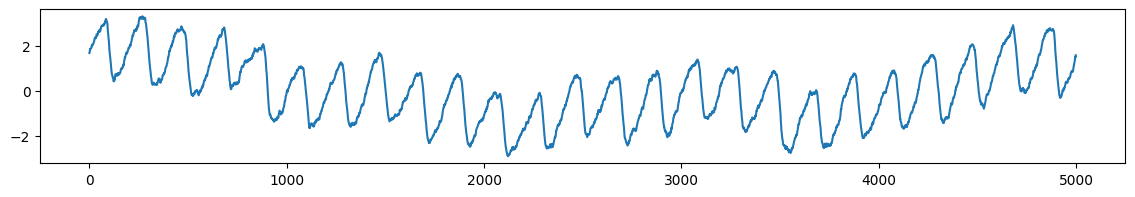

In [32]:
# Simulate
n_seconds = 5
fs = 1000

sig_pe = sim_oscillation(n_seconds, fs, 5, cycle="asine", rdsym=0.8)
sig_ap = sim_powerlaw(n_seconds, fs) / 1

sig = sig_pe + sig_ap

plt.figure(figsize=(14, 2))
plt.plot(sig);

## SSA

The main parameter of SSA is window size, which should be a integer multiple of the frequency of the target oscillation. Components with the lowest Hilbert transform variance are combined. The first mode is excluded as this reprents the trend of the signal$^1$, e.g. low frequency powerlaw fluctuations. 

In [47]:
# Initalize and run SSA
ssa = SSA(400, n_components=20)
ssa.fit(sig)

# Components are stored here for each signal
sig_components = ssa.sig_components[0]

# SVD is stored here
ssa.U, ssa.S, ssa.V ;

In [85]:
var_thresh = 0.1

# Low variance of signal components suggest a oscillatory eigenvector
amp_var = np.zeros(len(sig_components))
for i, s in enumerate(sig_components):
    a = amp_by_time(normalize_sig(s, 0, 1), fs)
    amp_var[i] = a[100:-100].var()

inds = np.where(amp_var[1:] < var_thresh)[0]+1

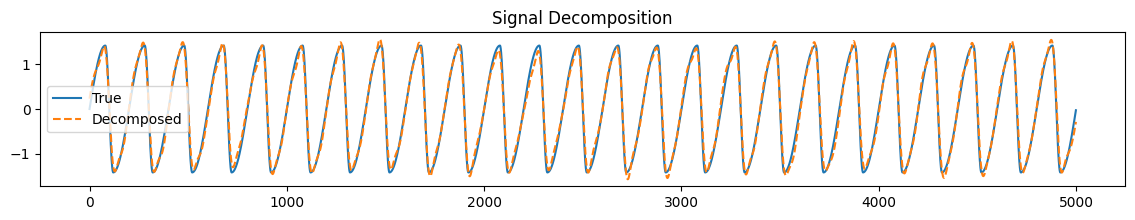

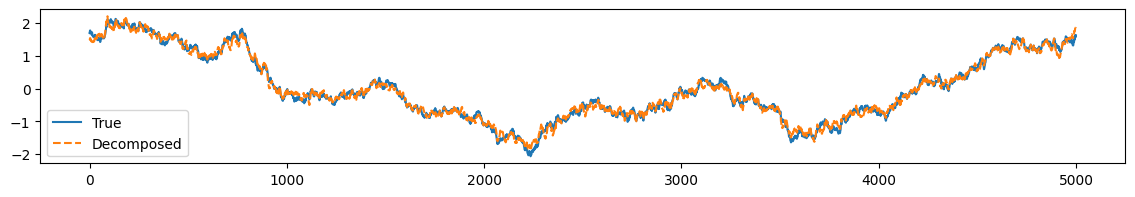

In [87]:
plt.figure(0, figsize=(14, 2))
plt.title('Signal Decomposition')
plt.plot(sig_pe, label='True')
plt.plot(sig_components[inds].sum(axis=0), label='Decomposed', ls='--')
plt.legend();

plt.figure(1, figsize=(14, 2))
plt.plot(sig_ap, label='True')
plt.plot(sig-sig_components[inds].sum(axis=0), label='Decomposed', ls='--')
plt.legend();